In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn as sns
from IPython.core.display_functions import display
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

today = datetime.datetime.today()
sns.set_theme()

In [119]:
def print_msg(msg):
    print("="*80)
    print(msg)
    print("="*80)

# Read in the data

In [120]:
original_df = pd.read_csv('car_price_data.csv')
df = original_df.copy(deep=True)

# Basic statistics

## Samples from the data

In [121]:
display(df.sample(5))

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
63,fortuner,2015,23.50,35.96,47000,Diesel,Dealer,Automatic,0
119,Royal Enfield Thunder 500,2013,1.05,1.90,5400,Petrol,Individual,Manual,0
122,Royal Enfield Bullet 350,2016,1.05,1.17,6000,Petrol,Individual,Manual,0
47,wagon r,2006,1.05,4.15,65000,Petrol,Dealer,Manual,0
211,elantra,2015,11.75,14.79,43535,Diesel,Dealer,Manual,0


## About the data

In [122]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


None

## Statistics of the data

# Data preparation

In [123]:
df.columns = df.columns.map(lambda x: x.lower())
df.drop(['car_name'], axis=1, inplace=True)
categorical_cols = ['fuel_type', 'seller_type', 'transmission', 'owner']
numerical_cols = ['selling_price', 'present_price', 'kms_driven', 'age']

## Replacing year with age of the car

In [124]:
df['age'] = today.year - df['year']
df.drop(['year'], axis=1, inplace=True)

## Information about the data

In [125]:
display(df.describe())

,selling_price,present_price,kms_driven,owner,age
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,4.661296,7.628472,36947.205980,0.043189,8.372093
std,5.082812,8.644115,38886.883882,0.247915,2.891554
min,0.100000,0.320000,500.000000,0.000000,4.000000
25%,0.900000,1.200000,15000.000000,0.000000,6.000000
50%,3.600000,6.400000,32000.000000,0.000000,8.000000
75%,6.000000,9.900000,48767.000000,0.000000,10.000000
max,35.000000,92.600000,500000.000000,3.000000,19.000000


# Exploring the data

## Plotting numerical data

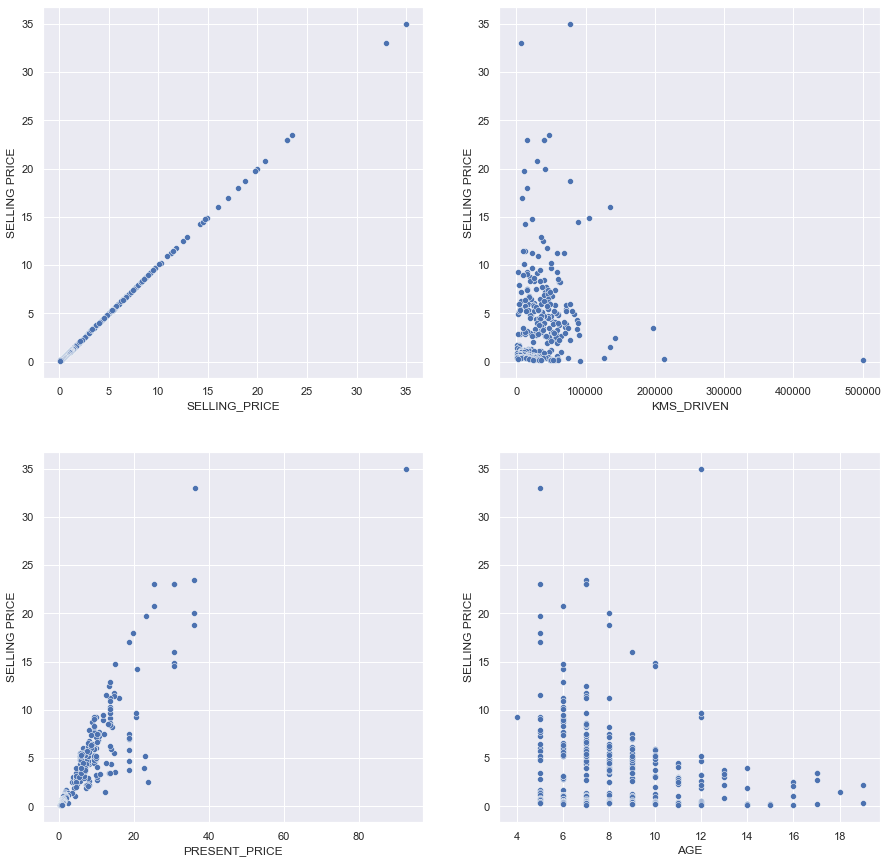

In [126]:
def plot_numerical_data():
    plot_cols = numerical_cols.copy()
    fig, ax = plt.subplots(2, len(plot_cols) // 2, figsize=(15, 15))
    for i, col in enumerate(plot_cols):
        cur_ax = ax[i%2, i//2]
        sns.scatterplot(x=df[col], y=df['selling_price'], ax=cur_ax)
        cur_ax.set_xlabel(col.upper())
        cur_ax.set_ylabel('SELLING PRICE')


plot_numerical_data()

## Plotting categorical data

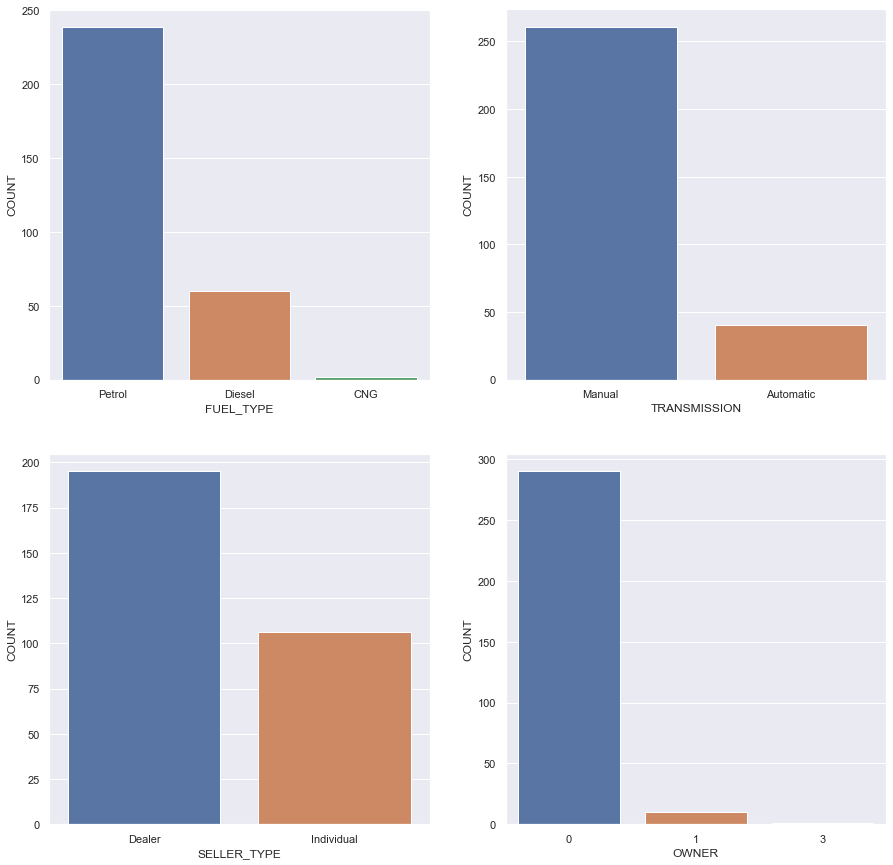

In [127]:
def plot_categorical_data():
    plot_cols = categorical_cols
    fig, ax = plt.subplots(2, len(plot_cols) // 2, figsize=(15, 15))
    for i, col in enumerate(plot_cols):
        cur_ax = ax[i%2, i//2]
        sns.countplot(x=col, data=df, ax=cur_ax)
        cur_ax.set_xlabel(col.upper())
        cur_ax.set_ylabel('COUNT')

plot_categorical_data()

## Plotting the outliers

In [128]:
def plot_outliers():
    plot_cols = numerical_cols
    fig, ax = plt.subplots(2, len(plot_cols) // 2, figsize=(15, 15))
    for i, col in enumerate(plot_cols):
        cur_ax = ax[i//2, i%2]
        sns.boxplot(x=col, data=df, ax=cur_ax)
        cur_ax.set_xlabel(col.upper())

## Plot before dropping outliers

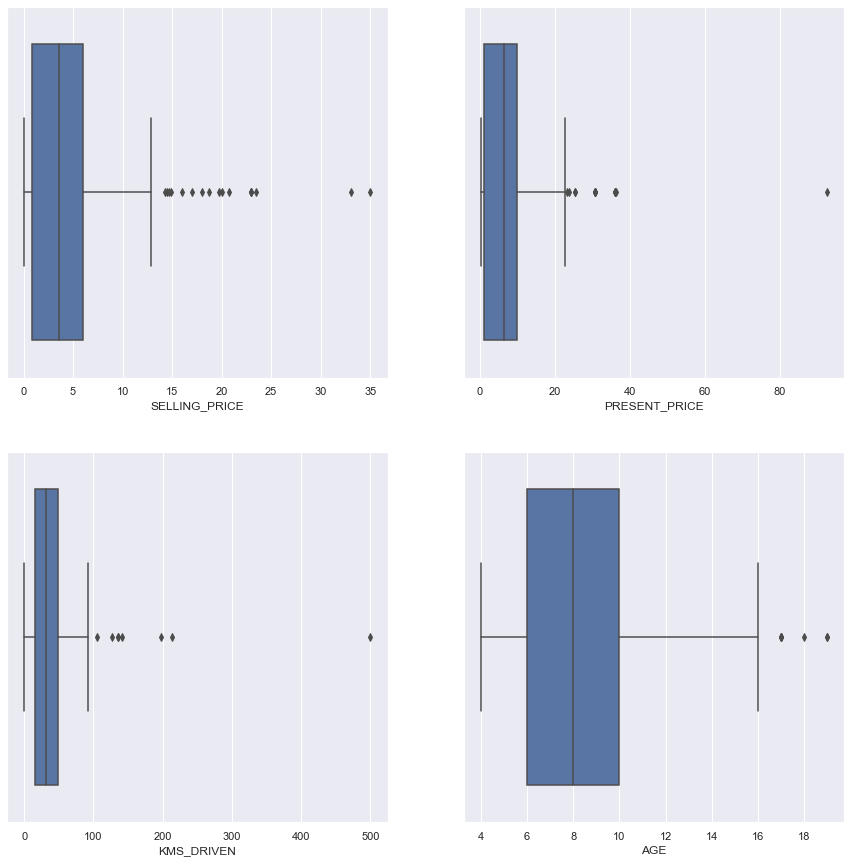

In [129]:
df['kms_driven'] = round(df['kms_driven'] / 1000, 3)
plot_outliers()

## Drop the outliers

In [130]:
def drop_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]
    data = data.dropna()
    return data

df = drop_outliers(df, 'selling_price')
df = drop_outliers(df, 'present_price')
df = drop_outliers(df, 'kms_driven')
df = drop_outliers(df, 'age')

## Plot after dropping outliers

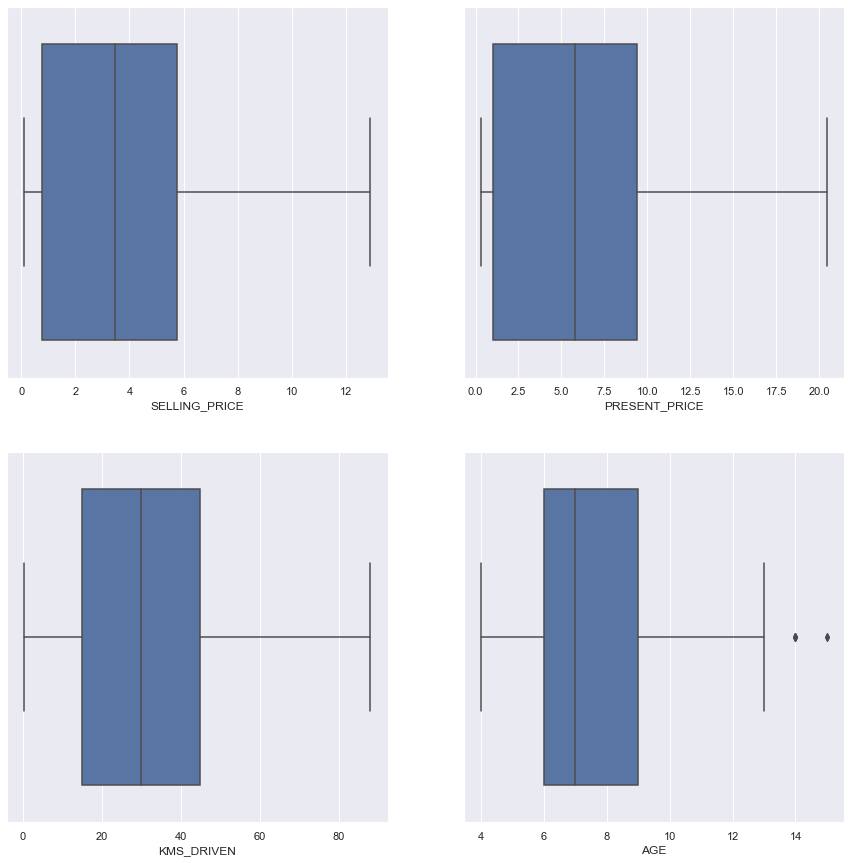

In [131]:
plot_outliers()

## Plotting correlation matrix

<AxesSubplot:>

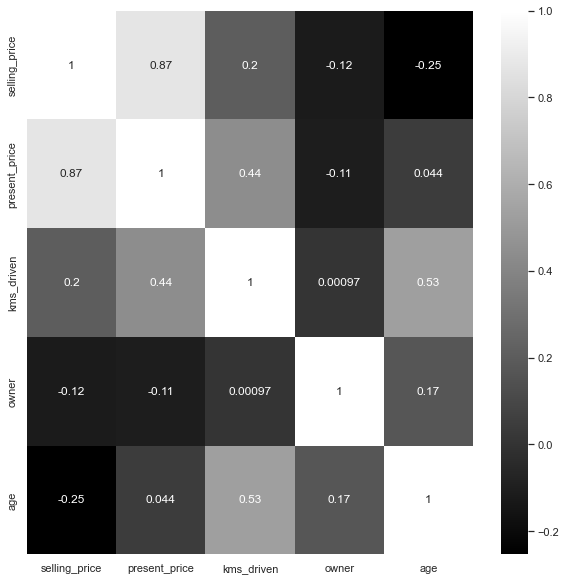

In [132]:
fig = plt.figure(figsize=(10, 10))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='gray', annot=True)

## Convert categorical data to dummy variables

In [133]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## Dropping features with high Variance Inflation Factor (VIF)

In [134]:
def get_vif(data):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif["features"] = data.columns
    return vif

def drop_by_vif(data, dropped_cols=None, threshold=10):
    if dropped_cols is None:
        dropped_cols = []
    vif = get_vif(data)
    max_vif = vif["VIF Factor"].max()
    if max_vif <= threshold:
        return vif, dropped_cols
    col_to_drop = vif[vif["VIF Factor"] == max_vif]["features"].values[0]
    print_msg("Need to drop feature \"{}\" with VIF \"{}\"".format(col_to_drop, round(max_vif, 2)))
    display(vif)
    dropped_cols.append(col_to_drop)
    data.drop(col_to_drop, axis=1, inplace=True)
    return drop_by_vif(data, dropped_cols, threshold)

In [135]:
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']
drop_threshold = 10

initial_vif = get_vif(X)
print_msg("Initial VIF (Before dropping features):")
display(initial_vif)
final_vif, cols_to_drop = drop_by_vif(X.copy(deep=True), threshold=drop_threshold)
print_msg("Final VIF (After dropping features with threshold \"{}\"):".format(drop_threshold))
display(final_vif)

Initial VIF (Before dropping features):


,VIF Factor,features
0,6.975323,present_price
1,7.058405,kms_driven
2,19.552141,age
3,6.034425,fuel_type_Diesel
4,22.501061,fuel_type_Petrol
5,4.133359,seller_type_Individual
6,11.667031,transmission_Manual
7,1.088076,owner_1


Need to drop feature "fuel_type_Petrol" with VIF "22.5"


,VIF Factor,features
0,6.975323,present_price
1,7.058405,kms_driven
2,19.552141,age
3,6.034425,fuel_type_Diesel
4,22.501061,fuel_type_Petrol
5,4.133359,seller_type_Individual
6,11.667031,transmission_Manual
7,1.088076,owner_1


Need to drop feature "age" with VIF "14.85"


,VIF Factor,features
0,5.309685,present_price
1,6.884100,kms_driven
2,14.846372,age
3,1.563838,fuel_type_Diesel
4,3.358380,seller_type_Individual
5,8.290393,transmission_Manual
6,1.082781,owner_1


Final VIF (After dropping features with threshold "10"):


,VIF Factor,features
0,4.724197,present_price
1,4.332166,kms_driven
2,1.486752,fuel_type_Diesel
3,2.590337,seller_type_Individual
4,6.717228,transmission_Manual
5,1.057800,owner_1


# Training and testing

## Train-Test split

In [136]:
X = sm.add_constant(X)
X.drop(cols_to_drop, axis=1, inplace=True)
seed = 100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Train the model

In [137]:
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     192.8
Date:                Thu, 05 May 2022   Prob (F-statistic):           4.39e-82
Time:                        10:39:51   Log-Likelihood:                -338.37
No. Observations:                 215   AIC:                             690.7
Df Residuals:                     208   BIC:                             714.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

In [138]:
model.params

const                     2.929651
present_price             0.435556
kms_driven               -0.042541
fuel_type_Diesel          1.367035
seller_type_Individual   -1.739023
transmission_Manual      -0.050047
owner_1                  -0.127263
dtype: float64

## Predicting car price from test set

In [139]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [140]:
np.random.seed(seed)
idx = np.random.choice(X_test.shape[0], 1, replace=False)[0]
print("Predicted selling price: {}".format(round(y_pred_test.iloc[idx], 2)))
print("Actual selling price: {}".format(y_test.iloc[idx]))

Predicted selling price: 5.32
Actual selling price: 5.2


## Calculating metrics

In [141]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.results_ = None
        self.model_ = None
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)


In [142]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print("R2 score on train set: {}".format(round(r2_train, 2)))
print("R2 score on test set: {}".format(round(r2_test, 2)))

cv_train = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, cv=5)
cv_train_mean = cv_train.mean()
print("Mean CV score on train set: {}".format(round(cv_train_mean, 2)))

R2 score on train set: 0.85
R2 score on test set: 0.85
Mean CV score on train set: 0.84


## Plotting

C:\Users\subhash\miniconda3\envs\econometrics\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y_test', ylabel='y_test_pred'>

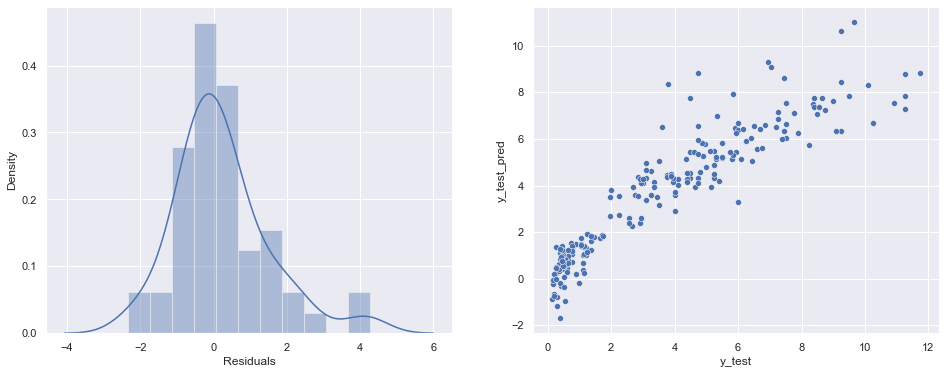

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# ax[0].set_title("Residuals on train set")
ax[0].set_xlabel("Residuals")
sns.distplot((y_test - y_pred_test), ax=ax[0])
# ax[1].set_title("Scatter plot between y_test and y_test_pred")
ax[1].set_xlabel("y_test")
ax[1].set_ylabel("y_test_pred")
sns.scatterplot(x=y_train, y=y_pred_train, ax=ax[1])

Text(0, 0.5, 'Residuals')

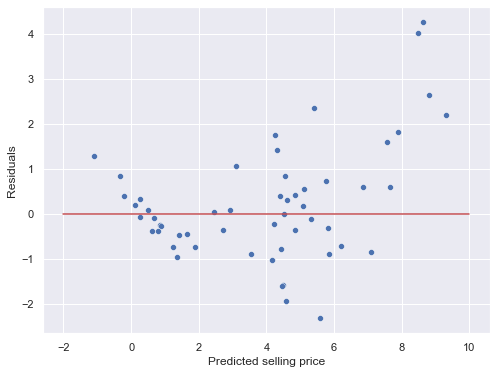

In [144]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_pred_test, y=(y_test - y_pred_test), ax=ax)
sns.lineplot(x=[-2, 10], y=[0, 0], color='r', ax=ax)
ax.set_xlabel("Predicted selling price")
ax.set_ylabel("Residuals")